<a href="https://colab.research.google.com/github/ajsanjoaquin/COVID-19-Scanner/blob/master/covidtesting_notebook(Resnet34).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#COVID-19 Diagnosis Triage Tool

This model is meant to identify priority patients to receive medical attention, particularly testing for COVID-19, based on their X-ray images scans and risk factors contained in the DICOM metadata.

This model is provided as-is, and not meant to diagnose  COVID-19. This model has no clinical approval, nor endorsements from any health organizations. At the moment, this model is for research and testing purposes. In no way is the author responsible for any damages resulting from using this model. 

Contact: [Ayrton San Joaquin](mailto:ayrton@u.yale-nus.edu.sg)

License: MIT 

#PURE PYTORCH IMPLEMENTATION

The model accepts both DICOM and standard image extensions (.png, .jpg, .jpeg).

The first code blocks below convert DICOM Images to png, if there are any

In [0]:
!pip install pydicom pypng

In [0]:
from torch import Tensor
from torch import nn
from torchvision import transforms
from torch.autograd import Variable
from PIL import Image
import torch, torchvision
import logging as log
from typing import Optional # required for "Optional[type]"
import os,re

import numpy as np
import pandas as pd

import cv2
import os
import pydicom
import png
import matplotlib.pyplot as plt
from matplotlib import rcParams

#put test images in test folder
if not os.path.isdir('test'):
  os.makedirs('test')

path_to_test='test/'

def get_metadata(folder,filename, attribute):
    '''
    Given a path to folder of images, patient ID, and attribute, return useful meta-data from the corresponding dicom image.
    IMPLICITLY Converts dicom image to png in the process and puts to test folder
    Returns attribute value, png image (implicit)
    '''
    ds=pydicom.dcmread(folder+'/'+filename+'.dcm')

    #implicit DICOM -> PNG conversion
    shape = ds.pixel_array.shape
    # Convert to float to avoid overflow or underflow losses.
    image_2d = ds.pixel_array.astype(float)
    # Rescaling grey scale between 0-255
    image_2d_scaled = (np.maximum(image_2d,0) / image_2d.max()) * 255.0
    # Convert to uint
    image_2d_scaled = np.uint8(image_2d_scaled)
    # Write the PNG file
    with open(os.path.join(folder,filename+'.png'), 'wb') as png_file:
        w = png.Writer(shape[1], shape[0], greyscale=True)
        w.write(png_file, image_2d_scaled)
    try: 
      attribute_value = getattr(ds, attribute)
      return attribute_value
    except: return np.NaN

###Upload your files before running the code blocks below.

In [0]:
#list of files to be converted
files = [f[:-4] for f in os.listdir(path_to_test) if f.endswith('.dcm')]
result_df=pd.DataFrame(files,columns=['filename'])

#list of essential attributes
attributes = ['PatientID','PatientSex', 'PatientAge', 'ViewPosition']
for a in attributes:
    result_df[a] = result_df['filename'].apply(lambda x: get_metadata(path_to_test, x, a))

##I. Model Instantiation

In [0]:
#download model
!wget -O corona_resnet34.pth https://www.dropbox.com/s/o27w0dik8hdjaab/corona_resnet34.pth?dl=0

In [0]:
#Code taken from Andrea de Luca (https://bit.ly/2YXW6xN)
## The code below gives you Flatten and the double Adaptive Pooling (from fastai), plus
## a viable head. You must fill the number of FC's nodes manually through the myhead function

#CPU for inference
device = torch.device("cpu")

class Flatten(nn.Module):
    "Flatten `x` to a single dimension, often used at the end of a model. `full` for rank-1 tensor"
    def __init__(self, full:bool=False):
        super().__init__()
        self.full = full

    def forward(self, x):
        return x.view(-1) if self.full else x.view(x.size(0), -1)

class AdaptiveConcatPool2d(nn.Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`." # from pytorch
    def __init__(self, sz:Optional[int]=None): 
        "Output will be 2*sz or 2 if sz is None"
        super().__init__()
        self.output_size = sz or 1
        self.ap = nn.AdaptiveAvgPool2d(self.output_size)
        self.mp = nn.AdaptiveMaxPool2d(self.output_size)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)
    
def myhead(nf, nc):
    '''
    Inputs: nf=  # of in_features in the 4th layer , nc= # of classes
    '''
    return \
    nn.Sequential(        # the dropout is needed otherwise you cannot load the weights
            AdaptiveConcatPool2d(),
            Flatten(),
            nn.BatchNorm1d(nf,eps=1e-05,momentum=0.1,affine=True,track_running_stats=True),
            nn.Dropout(p=0.25,inplace=False),
            nn.Linear(nf, 512,bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512,eps=1e-05,momentum=0.1,affine=True,track_running_stats=True),
            nn.Dropout(p=0.5,inplace=False),
            nn.Linear(512, nc,bias=True),
        )


my_model=torchvision.models.resnet34() 
modules=list(my_model.children())
modules.pop(-1) 
modules.pop(-1) 
temp=nn.Sequential(nn.Sequential(*modules))
tempchildren=list(temp.children()) 

#append the special fastai head
#Configured according to Model Architecture

tempchildren.append(myhead(1024,3))
model_r34=nn.Sequential(*tempchildren)

#LOAD MODEL
state = torch.load('corona_resnet34.pth',map_location=torch.device('cpu'))
model_r34.load_state_dict(state['model'])


#important to set to evaluation mode
model_r34.eval()


test_transforms = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
])

def predict_image(model,image):
    softmaxer = torch.nn.Softmax(dim=1)
    image_tensor = Image.open(image)
    image_tensor = image_tensor.convert('RGB')
    image_tensor = test_transforms(image_tensor).float()
    image_tensor=image_tensor.unsqueeze(0)

    #convert evaluation to probabilities with softmax
    with torch.no_grad(): #turn off backpropagation
      processed=softmaxer(model(image_tensor))
    return processed[0] #return probabilities

In [0]:
#accepts png files
test_files=[file for file in sorted(os.listdir(path_to_test))if file.endswith(('.png','.jpg','.jpeg'))]
pytorch_results={filename:predict_image(model_r34,path_to_test+filename) for filename in test_files}


###Results are saved in a .csv file in the colab workspace.

In [0]:
predictions_df=pd.DataFrame.from_dict(pytorch_results,orient='index',columns=['covid','nofinding','opacity']).rename_axis('filename').reset_index()
predictions_df['covid']=predictions_df['covid'].apply(lambda x: x.item())
predictions_df['nofinding']=predictions_df['nofinding'].apply(lambda x: x.item())
predictions_df['opacity']=predictions_df['opacity'].apply(lambda x: x.item())

#get the column name of the highest probability
predictions_df['Predicted Label'] =predictions_df[['covid','opacity','nofinding']].idxmax(axis=1)
predictions_df['filename']=predictions_df['filename'].str.slice(stop=-4) #remove .png suffix

#merge result_df and final_df
if result_df.empty:
  final_df=predictions_df
else:
  final_df=pd.merge(result_df,predictions_df[['filename','Predicted Label']], on='filename')
  #convert age to int to be used later
  final_df['PatientAge'] = pd.to_numeric(final_df['PatientAge'], errors='coerce')

final_df.to_csv('results.csv', header=True, index=False)

##II. Additionally, critical data taken from the DICOM file produces a hierarchical recommendation list of patients for medical attention

Currently, the 'Patient's Age' and 'View Position' have correlation with severity of COVID-19. AP view is usually meant for people who are incapacitated$^1$.
Threshold for age being tagged for attention is at $45^2$.

$^1$ https://radiopaedia.org/articles/chest-ap-erect-view-1
$^2$ https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/

In [0]:
#for priority action (usually testing) because the model predicts they exhibit COVID-19 Symptom/s 
for_testing_df=final_df[((final_df['Predicted Label']== 'opacity') | (final_df['Predicted Label']== 'covid'))]

#subset of priority testing who needs immediate attention (AP is usually taken when patient is incapacitated, 50 & above are likely to be severely affected)
critical_df=for_testing_df[(for_testing_df['ViewPosition']=='AP') | (for_testing_df['PatientAge'].astype('Int64') >= 50)]

In [0]:
#save results as csv file if they exist
if not for_testing_df.empty:
  for_testing_df.to_csv('Priority.csv',header=True, index=False)
if  not critical_df.empty:
  critical_df.to_csv('Critical_priority.csv',header=True, index=False)

##III. Grad-CAM Visualization (Optional)
Shows a heatmap of where in the image the model "looks" to make a decision. Grad-CAM is meant for model explainability. It is ideal for 'covid' and 'opacity' cases.


In [0]:
#@title Grad-CAM code with full-credit to Jimin Tan (https://github.com/tanjimin/grad-cam-pytorch-light)


class InfoHolder():

    def __init__(self, heatmap_layer):
        self.gradient = None
        self.activation = None
        self.heatmap_layer = heatmap_layer

    def get_gradient(self, grad):
        self.gradient = grad

    def hook(self, model, input, output):
        output.register_hook(self.get_gradient)
        self.activation = output.detach()

def generate_heatmap(weighted_activation):
    raw_heatmap = torch.mean(weighted_activation, 0)
    heatmap = np.maximum(raw_heatmap.detach().cpu(), 0)
    heatmap /= torch.max(heatmap) + 1e-10
    return heatmap.numpy()

def superimpose(input_img, heatmap):
    img = to_RGB(input_img)  
    heatmap = cv2.resize(heatmap, (img.shape[0], img.shape[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.uint8(heatmap * 0.6 + img * 0.4)
    pil_img = cv2.cvtColor(superimposed_img,cv2.COLOR_BGR2RGB)
    return pil_img

def to_RGB(tensor):
    tensor = (tensor - tensor.min())
    tensor = tensor/(tensor.max() + 1e-10)
    image_binary = np.transpose(tensor.numpy(), (1, 2, 0))
    image = np.uint8(255 * image_binary)
    return image

def grad_cam(model, input_tensor, heatmap_layer, truelabel=None):
    info = InfoHolder(heatmap_layer)
    heatmap_layer.register_forward_hook(info.hook)
    
    output = model(input_tensor.unsqueeze(0))[0]
    truelabel = truelabel if truelabel else torch.argmax(output)

    output[truelabel].backward()

    weights = torch.mean(info.gradient, [0, 2, 3])
    activation = info.activation.squeeze(0)

    weighted_activation = torch.zeros(activation.shape)
    for idx, (weight, activation) in enumerate(zip(weights, activation)):
        weighted_activation[idx] = weight * activation

    heatmap = generate_heatmap(weighted_activation)
    

    return superimpose(input_tensor, heatmap)

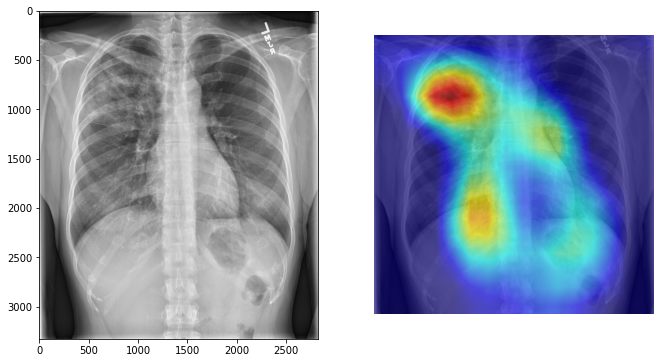

In [0]:
def use_gradcam(model,img_path,save=False):
  image=Image.open(img_path).convert('RGB')
  layer4=model[0][-1]
  heatmap_layer=layer4[2].conv2
  input_tensor=test_transforms(image)

  #get filename without extension
  filename=os.path.basename(img_path)[:-4]
  grad_image = grad_cam(model, input_tensor, heatmap_layer)
  if(save):
    plt.savefig(filename+'grad-cam')

  # figure size in inches
  rcParams['figure.figsize'] = 11 ,8

  #display figures
  fig, ax = plt.subplots(1,2)
  ax[0].imshow(image)
  plt.axis('off')
  ax[1].imshow(grad_image) 
  plt.axis('off')

use_gradcam(model_r34,'test/0.png')